In [129]:
import matplotlib.pyplot as plt
import numpy as np

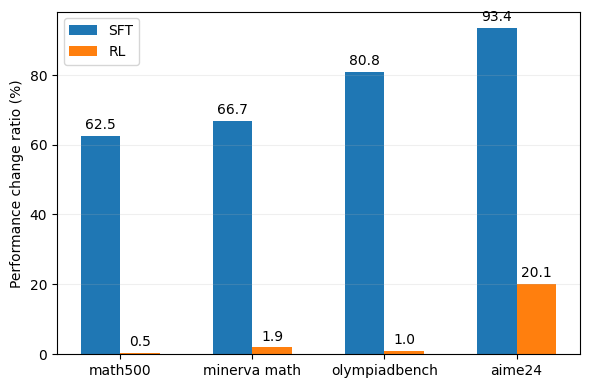

In [160]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.0)
fontsize = 15

ax.patch.set_facecolor('white')
# math500	minerva_math	olympiadbench	aime24
# 90.6	44.1	55.7	50
# 34	14.7	10.7	3.3
datasets = ['math500', 'minerva math', 'olympiadbench', 'aime24']
method1 = [90.6, 44.1, 55.7, 50.0]
method2 = [34.0, 14.7, 10.7, 3.3]
method1 = np.array(method1)
method2 = np.array(method2)
reduction = np.abs(method1 - method2)
# reduction = method2 - method1
reduction_ratio = reduction / method1
x = np.arange(len(datasets))
width = 0.3
rects1 = ax.bar(x - width/2, 100 * reduction_ratio, width, label='SFT', color='C0')

# math500	minerva_math	olympiadbench	aime24
# 87.2	41.2	57.6	33.3
# 87.6	40.4	57	40
method1 = [87.2, 41.2, 57.6, 33.3]
method2 = [87.6, 40.4, 57, 40]
method1 = np.array(method1)
method2 = np.array(method2)
reduction = np.abs(method1 - method2)
# reduction = method2 - method1
reduction_ratio = reduction / method1
rects2 = ax.bar(x + width/2, 100 * reduction_ratio, width, label='RL', color='C1')

# ax.set_xlabel('')
ax.set_ylabel('Performance change ratio (%)')
# ax.set_title('Performance change ratio')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()
ax.grid(axis='y', alpha=0.2)

# 在柱子上显示数值
for rects in [rects1, rects2]:
    ax.bar_label(rects, fmt='%.1f', padding=3)
 
plt.tight_layout()

# save_path = f"./dapo_32b.png"
# plt.savefig(save_path, dpi=300, bbox_inches='tight')# print(f"Saved plot for {metric} to {save_path}")


## DAPO 32B

In [24]:
import pandas as pd
import wandb
import os

# export 
os.environ["WANDB_API_KEY"] = ""
os.environ["WANDB_BASE_URL"] = "https://microsoft-research.wandb.io"

wandb.login(key="", host="https://microsoft-research.wandb.io", force=True)

api = wandb.Api()
runs = api.runs("lucliu/flash")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.


In [25]:
def get_df_from_runs(target_name="flash-baseline-T1-cleanedX"):
    runs_with_name = [r for r in runs if r.name == target_name]  # should be length 2

    dfs = []
    for run in runs_with_name:
        df = run.history(samples=1000, pandas=True)
        df["run_id"] = run.id
        dfs.append(df)

    # stack them
    df = pd.concat(dfs, ignore_index=True)
    
    df = df.dropna(subset=['val-core/math_dapo/acc/mean@32'])
    df = df.dropna(subset=['training/rollout_probs_diff_mean'])
    df = df.dropna(subset=['training/rollout_probs_diff_max'])
    df = df.sort_values(by=['_step', '_timestamp'])
    return df

In [71]:
dfs = {
    "DAPO (prob-diff agnostic)": get_df_from_runs(target_name="flash-baseline-T1-cleanedX"),
    # "DAPO w. fp32 lm-head (prob-diff agnostic)": get_df_from_runs(target_name="flash-bf16-fp32head-async-T1.0-cleanedX"),
    "DAPO w. TIS (prob-diff aware)": get_df_from_runs(target_name="flash-bf16-all-async-nclip2-sHack-T1-cleanedX"),
    "DAPO w. int8 (prob-diff aware)": get_df_from_runs(target_name="flash-w8a8-all-async-nclip5-sHack-T1.0-cleanedX"),
}

In [75]:
# dfs["DAPO (prob-diff agnostic)"]["perf/throughput"]

In [95]:
# Fix the index for "DAPO (prob-diff agnostic)" to have consistent intervals of 5
import numpy as np

# Get the current dataframe
df_dapo = dfs["DAPO (prob-diff agnostic)"].copy()

# Create the correct index with intervals of 5
# Starting from 5 and going up to the length of the dataframe
correct_index = np.arange(5, 5 + len(df_dapo) * 5, 5)

# Reset the index to the correct values
df_dapo.index = correct_index[:len(df_dapo)]

# Update the dictionary with the corrected dataframe
dfs["DAPO (prob-diff agnostic)"] = df_dapo

# Verify the fix
print("Original indices around the break:")
print("Index values from 140 to 165:", df_dapo.index[27:33].tolist())
print("\nFull corrected index:")
print(df_dapo.index)

Original indices around the break:
Index values from 140 to 165: [140, 145, 150, 155, 160, 165]

Full corrected index:
Index([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,
        75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135, 140,
       145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210,
       215, 220, 225, 230, 235, 240, 245, 250],
      dtype='int64')


In [96]:
# Check and verify the corrected index
print("Corrected index values from 140 to 165:")
print(dfs["DAPO (prob-diff agnostic)"].index[27:33].tolist())
print("\nAll index values should now have consistent intervals of 5:")
print(dfs["DAPO (prob-diff agnostic)"].index.tolist())

Corrected index values from 140 to 165:
[140, 145, 150, 155, 160, 165]

All index values should now have consistent intervals of 5:
[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250]


In [ ]:


runtime1 = dfs["DAPO (prob-diff agnostic)"][dfs["DAPO (prob-diff agnostic)"]["_step"] <= 145]["_runtime"]
runtime2 = dfs["DAPO (prob-diff agnostic)"][dfs["DAPO (prob-diff agnostic)"]["_step"] > 145]["_runtime"]

# 连接 runtime1 和 runtime2
combined_runtime = pd.concat([runtime1, runtime2 + runtime1.iloc[-1]], ignore_index=True)


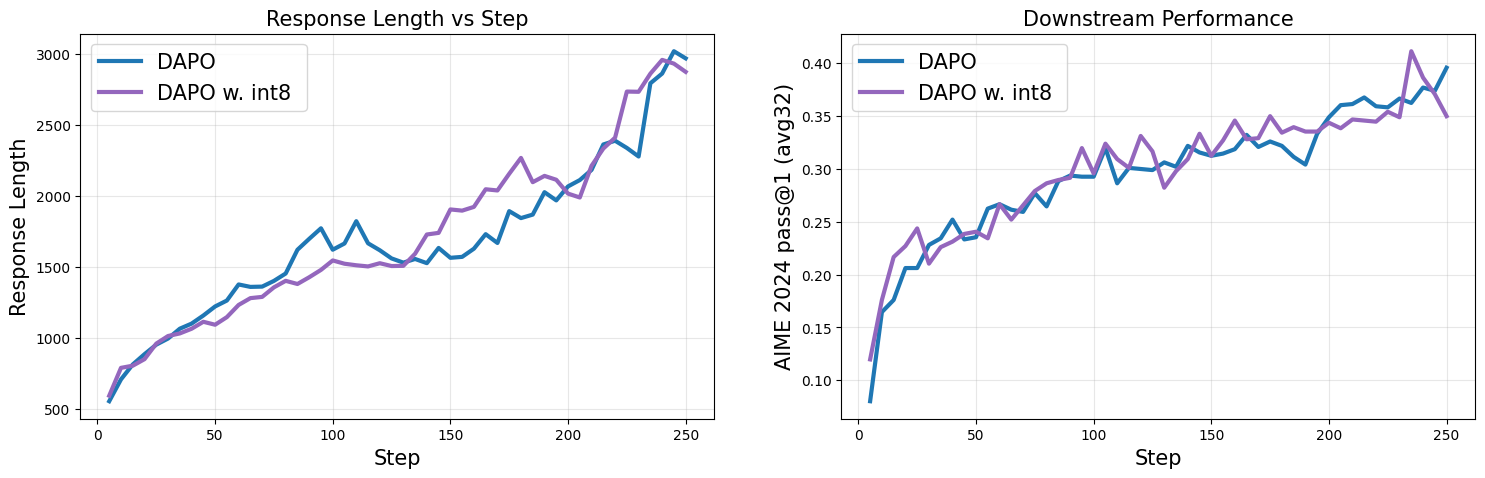

In [142]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.0)
fontsize = 15
colors = {
    "DAPO (prob-diff agnostic)": "C0",
    "DAPO w. TIS (prob-diff aware)": "C1",
    "DAPO w. fp32 lm-head (prob-diff agnostic)": "C3",
    "DAPO w. int8 (prob-diff aware)": "C4",
}
 
ax = axes[0]
ax.patch.set_facecolor('white')
for method in ["DAPO (prob-diff agnostic)", "DAPO w. int8 (prob-diff aware)"]:
        df = dfs[method]
        ax.plot(
                df["_step"], 
                df["response_length/mean"], 
                color=colors[method],
                lw=3, 
                # alpha=0.7,
                label=f'{method.split("(")[0]}')
ax.set_xlabel('Step', fontsize=fontsize)
ax.set_ylabel('Response Length', fontsize=fontsize)
ax.set_title('Response Length vs Step', fontsize=fontsize)
ax.legend(fontsize=fontsize)
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.patch.set_facecolor('white')
for method in ["DAPO (prob-diff agnostic)", "DAPO w. int8 (prob-diff aware)"]:
        df = dfs[method]
        ax.plot(
                df["_step"], 
                df["val-core/math_dapo/acc/mean@32"], 
                color=colors[method],
                lw=3, 
                # linestyle='--',
                # alpha=0.7,
                label=f'{method.split("(")[0]}')
ax.set_xlabel('Step', fontsize=fontsize)
ax.set_ylabel('AIME 2024 pass@1 (avg32)', fontsize=fontsize)
ax.set_title('Downstream Performance', fontsize=fontsize)
ax.legend(fontsize=fontsize)
ax.grid(True, alpha=0.3)
 
# plt.tight_layout()
save_path = f"./dapo_32b.png"
# plt.savefig(save_path, dpi=300, bbox_inches='tight')
# print(f"Saved plot for {metric} to {save_path}")

/var/folders/g7/mp4s41j53gl_gqw41fwh8nvh0000gn/T/ipykernel_29758/803714941.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=fontsize)


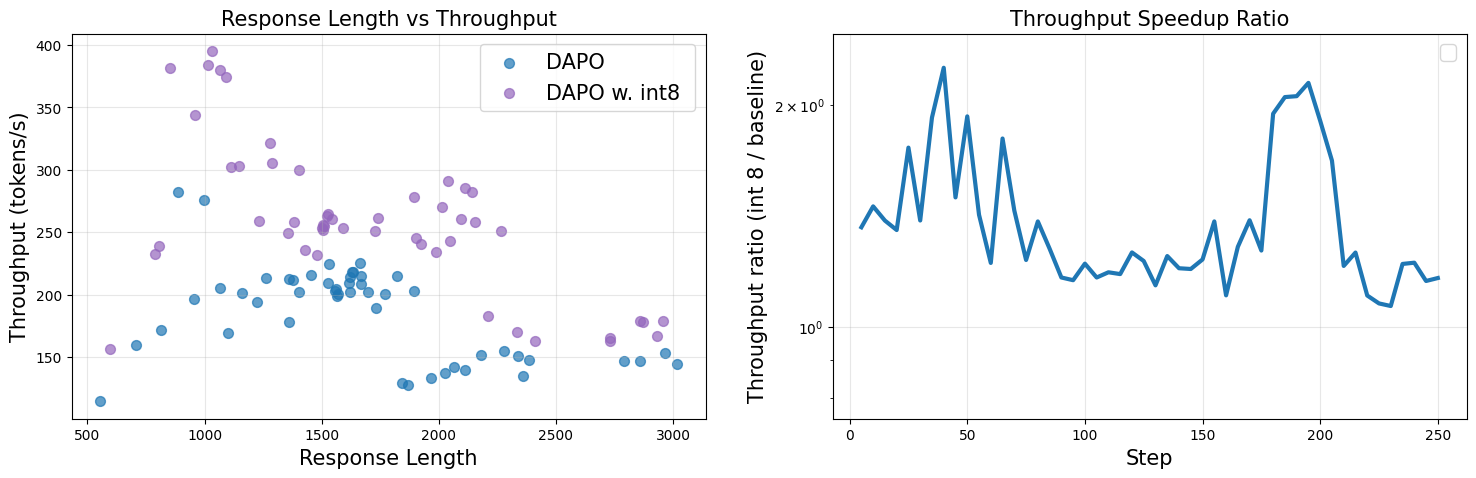

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.0)
fontsize = 15
colors = {
    "DAPO (prob-diff agnostic)": "C0",
    "DAPO w. TIS (prob-diff aware)": "C1",
    "DAPO w. fp32 lm-head (prob-diff agnostic)": "C3",
    "DAPO w. int8 (prob-diff aware)": "C4",
}

# ax = axes[0]
# ax.patch.set_facecolor('white')
# for method in ["DAPO (prob-diff agnostic)", "DAPO w. fp32 lm-head (prob-diff agnostic)"]: # , "Decoupled"]:
#     df = dfs[method]
#     ax.plot(df["_step"], df["training/rollout_probs_diff_max"], lw=3,
#             color=colors[method],
#             label=f'{method.split("(")[0]}, ' + 'Max over tokens')
#     ax.plot(df["_step"], df["training/rollout_probs_diff_mean"], lw=3,
#             linestyle='--', # color='C0',
#             color=colors[method],
#             label=f'{method.split("(")[0]}, ' + 'Mean over tokens')
# ax.set_yscale('log')
# ax.set_xlabel('Step', fontsize=fontsize)
# ax.set_title('Token Probability Difference \n $(p^{\mathrm{vllm}}_t - p^{\mathrm{fsdp}}_t)$', fontsize=fontsize)
# ax.legend(fontsize=fontsize)

ax = axes[0]
ax.patch.set_facecolor('white')
for method in ["DAPO (prob-diff agnostic)", "DAPO w. int8 (prob-diff aware)"]:
        df = dfs[method]
        ax.scatter(
                df["response_length/mean"], 
                df["perf/throughput"], 
                s=50,
                color=colors[method],
                alpha=0.7,
                label=f'{method.split("(")[0]}')
ax.set_xlabel('Response Length', fontsize=fontsize)
ax.set_ylabel('Throughput (tokens/s)', fontsize=fontsize)
ax.set_title('Response Length vs Throughput', fontsize=fontsize)
ax.legend(fontsize=fontsize)
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.patch.set_facecolor('white')
ax.plot(
    dfs["DAPO (prob-diff agnostic)"]["_step"],
    dfs["DAPO w. int8 (prob-diff aware)"]["perf/throughput"]/ dfs["DAPO (prob-diff agnostic)"]["perf/throughput"],
     lw=3,
    # color=colors["DAPO (prob-diff agnostic)"],
    # label="ratio"
    )
ax.set_ylim(0.75, 2.5)
ax.set_yscale('log')
ax.set_xlabel('Step', fontsize=fontsize)
ax.set_ylabel('Throughput ratio (int 8 / baseline)', fontsize=fontsize)
ax.set_title('Throughput Speedup Ratio', fontsize=fontsize)
ax.legend(fontsize=fontsize)
ax.grid(True, alpha=0.3)

# ax = axes[1]
# ax.patch.set_facecolor('white')
# ax.plot(
# #     combined_runtime,
#     dfs["DAPO (prob-diff agnostic)"]["_step"],
#     dfs["DAPO (prob-diff agnostic)"]["val-core/math_dapo/acc/mean@32"], lw=3,
#     color=colors["DAPO (prob-diff agnostic)"],
#     label="DAPO (prob-diff agnostic)"
#     )
# for method in ["DAPO w. int8 (prob-diff aware)"]:
#     ax.plot(
#             dfs[method]["_step"],
#         #     dfs[method]["_runtime"],
#             dfs[method]["val-core/math_dapo/acc/mean@32"], lw=3,
#             color=colors[method],
#             label=method)
# # ax.set_xlabel('Runtime (s)', fontsize=fontsize)
# ax.set_xlabel('Step', fontsize=fontsize)
# ax.set_title('AIME 2024 \n pass@1 (avg32)', fontsize=fontsize)
# ax.legend(fontsize=fontsize)

save_path = f"./dapo_32b.png"
# plt.savefig(save_path, dpi=300, bbox_inches='tight')
# print(f"Saved plot for {metric} to {save_path}")

## GSM8K 

In [ ]:
import pandas as pd
import wandb
import os

# export 
os.environ["WANDB_API_KEY"] = "local-"
os.environ["WANDB_BASE_URL"] = "https://microsoft-research.wandb.io"

wandb.login(key="local-")

api = wandb.Api()
runs = api.runs("lucliu/GSM8K-PPO-new")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for microsoft-research.wandb.io to your netrc file: /root/.netrc


In [ ]:
def get_df_from_runs(target_name="flash-baseline-T1-cleanedX"):
    runs_with_name = [r for r in runs if r.name == target_name]  # should be length 2

    dfs = []
    for run in runs_with_name:
        df = run.history(samples=1000, pandas=True)
        df["run_id"] = run.id
        dfs.append(df)

    # stack them
    df = pd.concat(dfs, ignore_index=True)
    
    df = df.dropna(subset=['training/rollout_probs_diff_mean'])
    df = df.dropna(subset=['training/rollout_probs_diff_max'])
    df = df.sort_values(by=['_step', '_timestamp'])
    return df

In [ ]:
def get_eval_from_runs(target_name="flash-baseline-T1-cleanedX"):
    gsm8k = pd.read_csv('gsm8k_eval.csv')
    df = gsm8k[['step', target_name]].copy()
    df['gsm8k'] = df[target_name]
    return df

In [ ]:
dfs = {
    "PPO (prob-diff agnostic)": get_df_from_runs(target_name="gsm8k-PPO-Qwen2.5-0.5B-bf16-sync-case_study"),
    "PPO w. TIS (prob-diff aware)": get_df_from_runs(target_name="gsm8k-PPO-Qwen2.5-0.5B-bf16-redhat-async-api5-nclip2-case_study-378"),
}

In [ ]:
dfs_eval = {
    "PPO (prob-diff agnostic)": get_eval_from_runs(target_name="bf16"),
    "PPO w. TIS (prob-diff aware)": get_eval_from_runs(target_name="bf16-bf16eval-nclip2-decoupled-api5.0-378"),
}

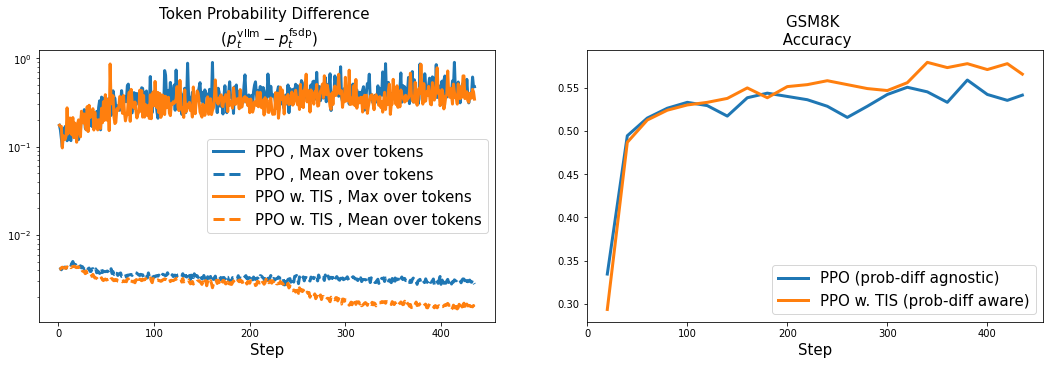

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
fig.patch.set_facecolor('white')
fontsize = 15
colors = {
    "PPO (prob-diff agnostic)": "C0",
    "PPO w. TIS (prob-diff aware)": "C1",
}


ax = axes[0]
ax.patch.set_facecolor('white')
for method in ["PPO (prob-diff agnostic)", "PPO w. TIS (prob-diff aware)"]: # , "Decoupled"]:
    df = dfs[method]
    ax.plot(df["_step"], df["training/rollout_probs_diff_max"], lw=3,
            color=colors[method],
            label=f'{method.split("(")[0]}, ' + 'Max over tokens')
    ax.plot(df["_step"], df["training/rollout_probs_diff_mean"], lw=3,
            linestyle='--', # color='C0',
            color=colors[method],
            label=f'{method.split("(")[0]}, ' + 'Mean over tokens')
ax.set_yscale('log')
ax.set_xlabel('Step', fontsize=fontsize)
ax.set_title('Token Probability Difference \n $(p^{\mathrm{vllm}}_t - p^{\mathrm{fsdp}}_t)$', fontsize=fontsize)
ax.legend(fontsize=fontsize)


ax = axes[1]
ax.patch.set_facecolor('white')
for method in ["PPO (prob-diff agnostic)", "PPO w. TIS (prob-diff aware)"]:
    ax.plot(dfs_eval[method]["step"], 
            dfs_eval[method]["gsm8k"], lw=3,
            color=colors[method],
            label=method)
ax.set_xlabel('Step', fontsize=fontsize)
ax.set_title('GSM8K \n Accuracy', fontsize=fontsize)
ax.legend(fontsize=fontsize)


save_path = f"./gsm8k_bf16.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
# print(f"Saved plot for {metric} to {save_path}")

## GSM8K Int8

In [ ]:
def get_df_from_runs(target_name="flash-baseline-T1-cleanedX"):
    runs_with_name = [r for r in runs if r.name == target_name]  # should be length 2

    dfs = []
    for run in runs_with_name:
        df = run.history(samples=1000, pandas=True)
        df["run_id"] = run.id
        dfs.append(df)

    # stack them
    df = pd.concat(dfs, ignore_index=True)
    
    df = df.dropna(subset=['training/rollout_probs_diff_mean'])
    df = df.dropna(subset=['training/rollout_probs_diff_max'])
    df = df.sort_values(by=['_step', '_timestamp'])
    return df

# export 
os.environ["WANDB_API_KEY"] = "local-"
os.environ["WANDB_BASE_URL"] = "https://microsoft-research.wandb.io"

wandb.login(key="local-")

api = wandb.Api()
runs = api.runs("lucliu/GSM8K-PPO-new")

dfs = {
    "PPO": get_df_from_runs(target_name="gsm8k-PPO-Qwen2.5-0.5B-bf16-sync-case_study"),
    "PPO w. TIS": get_df_from_runs(target_name="gsm8k-PPO-Qwen2.5-0.5B-bf16-redhat-async-api5-nclip2-case_study-378"),
    "PPO-Int8 Rollout": get_df_from_runs(target_name="gsm8k-PPO-Qwen2.5-0.5B-w8a8-redhat-sync-api5-case_study-378"),
    "PPO-Int8 Rollout w. TIS": get_df_from_runs(target_name="gsm8k-PPO-Qwen2.5-0.5B-w8a8-redhat-sHack-async-api5-nclip2-case_study"),
}

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for microsoft-research.wandb.io to your netrc file: /root/.netrc


In [ ]:
dfs_eval = {
    "PPO": get_eval_from_runs(target_name="bf16"),
    "PPO w. TIS": get_eval_from_runs(target_name="bf16-bf16eval-nclip2-decoupled-api5.0-378"),
    "PPO-Int8 Rollout w. TIS": get_eval_from_runs(target_name="int8-bf16eval-nclip2-decoupled-api5.0-376"),
    "PPO-Int8 Rollout": get_eval_from_runs(target_name="int8"),
}

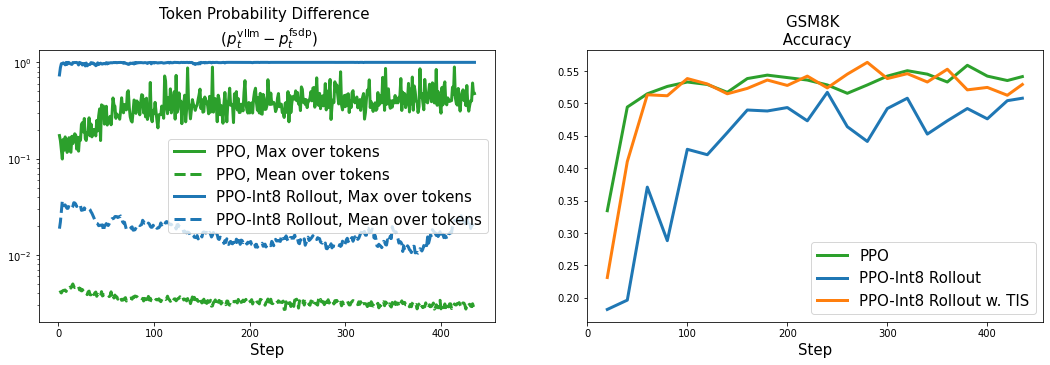

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
fig.patch.set_facecolor('white')
fontsize = 15
colors = {
    "PPO": "C2",
#     "PPO w. TIS": "C3",
    "PPO-Int8 Rollout": "C0",
    "PPO-Int8 Rollout w. TIS": "C1",
}


ax = axes[0]
ax.patch.set_facecolor('white')
for method in ["PPO", "PPO-Int8 Rollout"]: # , "Decoupled"]:
    df = dfs[method]
    ax.plot(df["_step"], df["training/rollout_probs_diff_max"], lw=3,
            color=colors[method],
            label=f'{method.split("(")[0]}, ' + 'Max over tokens')
    ax.plot(df["_step"], df["training/rollout_probs_diff_mean"], lw=3,
            linestyle='--', # color='C0',
            color=colors[method],
            label=f'{method.split("(")[0]}, ' + 'Mean over tokens')
ax.set_yscale('log')
ax.set_xlabel('Step', fontsize=fontsize)
ax.set_title('Token Probability Difference \n $(p^{\mathrm{vllm}}_t - p^{\mathrm{fsdp}}_t)$', fontsize=fontsize)
ax.legend(fontsize=fontsize)


ax = axes[1]
ax.patch.set_facecolor('white')
for method in ["PPO", "PPO-Int8 Rollout", "PPO-Int8 Rollout w. TIS"]:
    ax.plot(dfs_eval[method]["step"],
            dfs_eval[method]["gsm8k"],
            color=colors[method], lw=3,
            label=method)
ax.set_xlabel('Step', fontsize=fontsize)
ax.set_title('GSM8K \n Accuracy', fontsize=fontsize)
ax.legend(fontsize=fontsize)


save_path = f"./gsm8k_int8.png"
plt.savefig(save_path, dpi=300,  bbox_inches='tight')
# print(f"Saved plot for {metric} to {save_path}")

## DAPO 1.5B

In [ ]:
def get_df_from_runs(target_name="flash-baseline-T1-cleanedX"):
    runs_with_name = [r for r in runs if r.name == target_name]  # should be length 2

    dfs = []
    for run in runs_with_name:
        df = run.history(samples=1000, pandas=True)
        df["run_id"] = run.id
        dfs.append(df)

    # stack them
    df = pd.concat(dfs, ignore_index=True)
    
    df = df.dropna(subset=['val-core/math_dapo/acc/mean@32'])
    df = df.dropna(subset=['training/rollout_probs_diff_mean'])
    df = df.dropna(subset=['training/rollout_probs_diff_max'])
    df = df.sort_values(by=['_step', '_timestamp'])
    return df

In [ ]:

api = wandb.Api()
runs = api.runs("lucliu/flash")

dfs = {
    "DAPO (prob-diff agnostic)": get_df_from_runs(target_name="flash-bf16-all-sHack-T1-cleaned-ds"),
    "DAPO w. TIS (prob-diff aware)": get_df_from_runs(target_name="flash-bf16-all-async-nclip10-sHack-T1-cleaned-ds"),
}

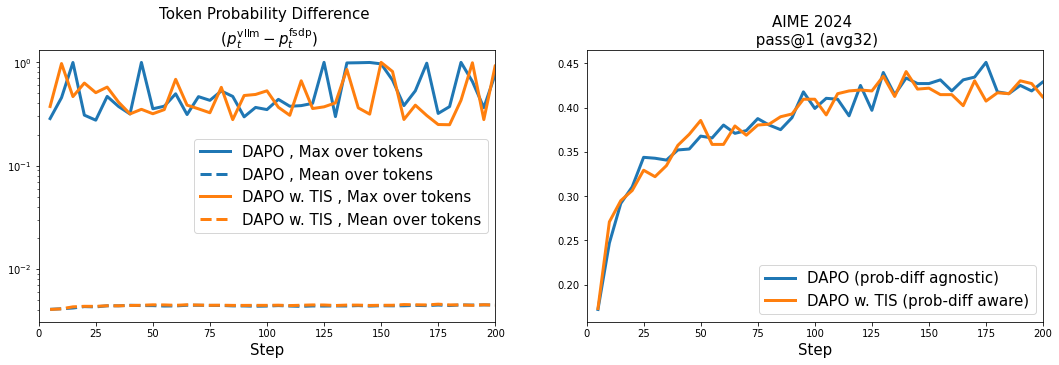

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
fig.patch.set_facecolor('white')
fontsize = 15
colors = {
    "DAPO (prob-diff agnostic)": "C0",
    "DAPO w. TIS (prob-diff aware)": "C1",
}


ax = axes[0]
for method in ["DAPO (prob-diff agnostic)", "DAPO w. TIS (prob-diff aware)"]: # , "Decoupled"]:
    df = dfs[method]
    ax.plot(df["_step"], df["training/rollout_probs_diff_max"],
            color=colors[method], lw=3,
            label=f'{method.split("(")[0]}, ' + 'Max over tokens')
    ax.plot(df["_step"], df["training/rollout_probs_diff_mean"],
            linestyle='--', # color='C0',
            color=colors[method], lw=3,
            label=f'{method.split("(")[0]}, ' + 'Mean over tokens')
ax.set_yscale('log')
ax.set_xlabel('Step', fontsize=fontsize)
ax.set_xlim(0, 200)
ax.set_title('Token Probability Difference \n $(p^{\mathrm{vllm}}_t - p^{\mathrm{fsdp}}_t)$', fontsize=fontsize)
ax.legend(fontsize=fontsize)


ax = axes[1]
for method in ["DAPO (prob-diff agnostic)", "DAPO w. TIS (prob-diff aware)"]:
    ax.plot(dfs[method]["_step"],
            dfs[method]["val-core/math_dapo/acc/mean@32"],
            color=colors[method], lw=3,
            label=method)
ax.set_xlabel('Step', fontsize=fontsize)
ax.set_xlim(0, 200)
ax.set_title('AIME 2024 \n pass@1 (avg32)', fontsize=fontsize)
ax.legend(fontsize=fontsize)


save_path = f"./dapo_1.5B.png"
plt.savefig(save_path, dpi=300,  bbox_inches='tight')
# print(f"Saved plot for {metric} to {save_path}")